# Journal 04: Building on The Last Journal: Increasing Sample-Size and Further Pre-Processing

So in '03' we gathered information about the distributions regarding from the `OCHL` metrics `('Open', 'Close/Last', 'High', 'Low')`. This information is to be used for the sake of generating a realistic distribution so we can simulate those sorts of trends in our simulation.

Here we are going to expand on this concept by utilizing more datasets. I've already drafted up a few functitons built on the the previous day's work, essentially extracting the main parts and generalizing them so we can use them for multiple files in one go. 

### Reading and Processing Data

We're going to start with reading in the files and properly pre-processing them first. We accomplish a few things here:

- Extracting the Stock's Label and incorporating that in the full 'Stock Market', so we can differentiate between each stock.
- Shifting the `Volume` column over one to the left (personal preference, as it makes more sense to me to leave the OCHL data together)
- Processing the OCHL columns by removing `'$'` and changing them to `float64` values
- Passing a parameter to specify whether we want only the OCHL values or the full dataset

In [200]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [201]:
def read_clean_data(file, ochl_only=False):
    file_path = 'data/' + file

    data = pd.read_csv(file_path)

    filename = file.split('_')
    stock_label = filename[0]

    data.insert(0, 'Label', value=stock_label)
    
    vol = data.pop('Volume')
    data.insert(2, 'Volume', vol)

    ochl_columns = ['Open', 'Close/Last', 'High', 'Low']

    for column in ochl_columns:
        data[column] = data[column].str.replace('$', '').astype('float64')

    if ochl_only:
        return data[ochl_columns]

    return data


stocks_ochl_analyzed = read_clean_data('AAPL_historical.csv', ochl_only=False)

stocks_ochl_analyzed.head()

,Label,Date,Volume,Close/Last,Open,High,Low
0,AAPL,09/27/2023,66921810,170.43,172.62,173.040,169.05
1,AAPL,09/26/2023,64588950,171.96,174.82,175.200,171.66
2,AAPL,09/25/2023,46172740,176.08,174.20,176.970,174.15
3,AAPL,09/22/2023,56725390,174.79,174.67,177.079,174.05
4,AAPL,09/21/2023,63149120,173.93,174.55,176.300,173.86


Obviously, since we are going to be throwing together some 9-10 stock datasets, it will be important to be able to differentiate between them all. This is also useful when we eventually come to plot all this information graphically.

Now, lets try and throw two stocks together to see if we can concatenate them together without too much trouble:

In [202]:
def gather_stock_data(filenames):
    data = []

    for file in filenames:
        data_set = read_clean_data(file)
        data.append(data_set)
    
    stock_market = pd.concat(data, axis=0, ignore_index=1)

    return stock_market


filenames = ['AAPL_historical.csv', 'MSFT_historical.csv']

stock_market = gather_stock_data(filenames)

stock_market.head()


,Label,Date,Volume,Close/Last,Open,High,Low
0,AAPL,09/27/2023,66921810,170.43,172.62,173.040,169.05
1,AAPL,09/26/2023,64588950,171.96,174.82,175.200,171.66
2,AAPL,09/25/2023,46172740,176.08,174.20,176.970,174.15
3,AAPL,09/22/2023,56725390,174.79,174.67,177.079,174.05
4,AAPL,09/21/2023,63149120,173.93,174.55,176.300,173.86


In [203]:
pd.value_counts(stock_market['Label'])

Label
AAPL    2516
MSFT    2516
Name: count, dtype: int64

Let's try with all of them real quick:

In [204]:
import os

data_folder = 'data'
filenames = os.listdir(data_folder)

filenames

['AAPL_historical.csv',
 'AMD_historical.csv',
 'AMZN_historical.csv',
 'CSCO_historical.csv',
 'META_historical.csv',
 'MSFT_historical.csv',
 'NFLX_historical.csv',
 'QCOM_historical.csv',
 'SBUX_historical.csv',
 'TSLA_historical.csv']

In [205]:
stock_market = gather_stock_data(filenames)

pd.value_counts(stock_market['Label'])

Label
AAPL    2516
AMD     2516
AMZN    2516
CSCO    2516
META    2516
MSFT    2516
NFLX    2516
QCOM    2516
SBUX    2516
TSLA    2516
Name: count, dtype: int64

Awesome! It works and now we have 10 stocks to work with in creating the distributions based on the last journal's work.

Let's bring in the other functions that I drafted up to perform the analysis we did previously for this whole dataset.


### Generating Rough Distributions 

To the analysis:

In [206]:
def identify_candle_color(data):
    color = []

    for ind in data.index:
        if data['Open'][ind] < data['Close/Last'][ind]:
            color.append('g')
        else:
            color.append('r')

    data['Color'] = color

    return data

def distribution_analysis(data):

    data['avg_all'] = data.mean(axis=1)

    data['avg_op_cl'] = data[['Open', 'Close/Last']].mean(axis=1)
    data['avg_hi_lo'] = data[['High', 'Low']].mean(axis=1)
    data['all_avg_to_hi'] = data[['avg_all', 'High']].mean(axis=1)
    data['all_avg_to_lo'] = data[['avg_all', 'Low']].mean(axis=1)

    data['dist_op_cl'] = data['Open'] - data['Close/Last']
    data['dist_hi_lo'] = data['High'] - data['Low']
    data['dist_avg_all_hi'] = data['High'] - data['avg_all']
    data['dist_avg_all_lo'] = data['avg_all'] - data['Low']
    data['dist_avg_all_op'] = data['Open'] - data['avg_all']
    data['dist_avg_all_cl'] = data['avg_all'] - data['Close/Last']

    data = identify_candle_color(data)

    greens = data[data['Color'] == 'g']
    reds = data[data['Color'] == 'r']

    data['g_dist_op_lo'] = greens['Open'] - greens['Low']
    data['g_dist_cl_hi'] = greens['High'] - greens['Close/Last']

    data['r_dist_op_hi'] = reds['High'] - reds['Open']
    data['r_dist_cl_lo'] = reds['Close/Last'] - reds['Low']

    colors = data.pop('Color')
    data['Color'] = colors

    return data


def extract_ochl(data):
    ochl_columns = ['Close/Last', 'Open', 'High', 'Low']
    ochl_data = data[ochl_columns]

    return ochl_data

In [207]:
stocks_ochl = extract_ochl(stock_market)

stocks_ochl_analyzed = distribution_analysis(stocks_ochl)

C:\Users\kylec\AppData\Local\Temp\ipykernel_31128\1263949640.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_all'] = data.mean(axis=1)
C:\Users\kylec\AppData\Local\Temp\ipykernel_31128\1263949640.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_op_cl'] = data[['Open', 'Close/Last']].mean(axis=1)


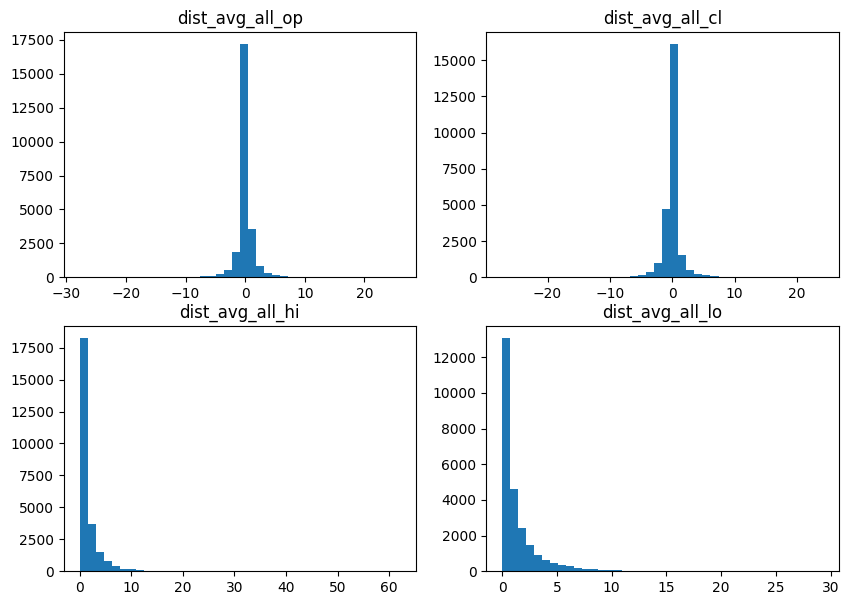

In [208]:
bin_size = 40

plt.figure(figsize=(10, 7))

plt.subplot(2, 2, 1)
plt.hist(stocks_ochl_analyzed['dist_avg_all_op'], bins=bin_size)
plt.title('dist_avg_all_op')

plt.subplot(2, 2, 2)
plt.hist(stocks_ochl_analyzed['dist_avg_all_cl'], bins=bin_size)
plt.title('dist_avg_all_cl')

plt.subplot(2, 2, 3)
plt.hist(stocks_ochl_analyzed['dist_avg_all_hi'], bins=bin_size)
plt.title('dist_avg_all_hi')

plt.subplot(2, 2, 4)
plt.hist(stocks_ochl_analyzed['dist_avg_all_lo'], bins=bin_size)
plt.title('dist_avg_all_lo')

plt.show()

Alright, it looks like we are pretty much getting the same information before, just with more concentration around the mean values, which is ok, but part of me is slightly worried that this is not going to cut it when it comes to attempting to simulate the real deal. So instead we are going to gather different metrics that capture the same information goal ***BUT*** in a different format: *Percentages*.

Why percentages? Well, lets look at the price distributions of each stock:

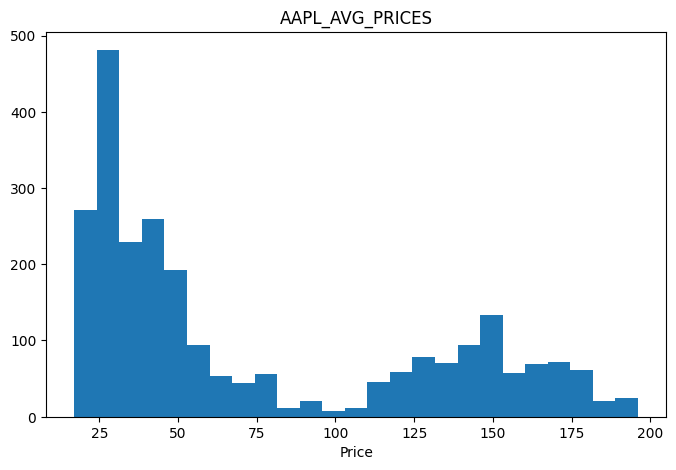

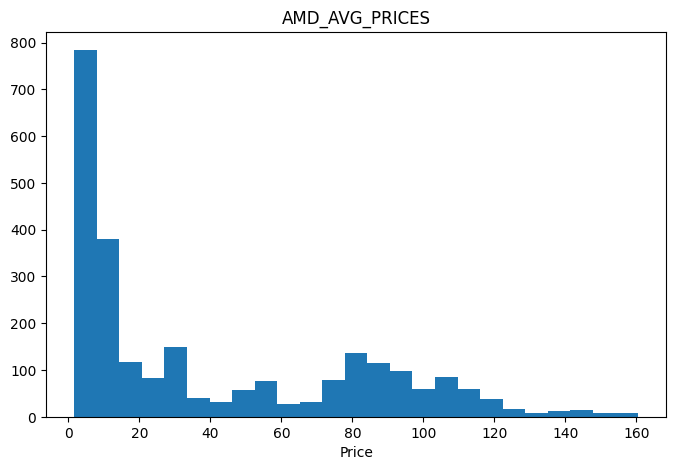

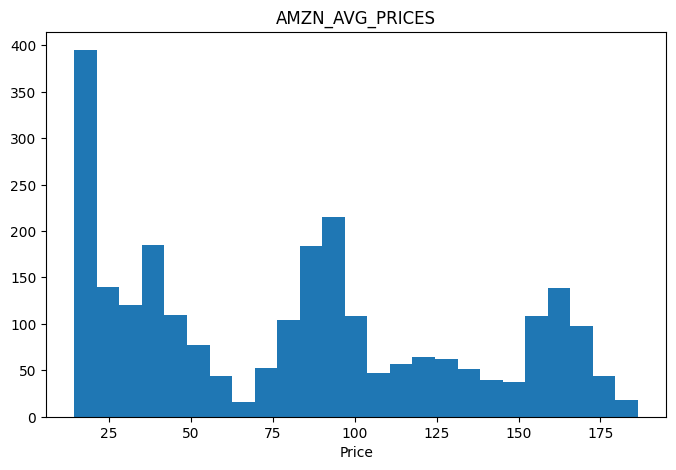

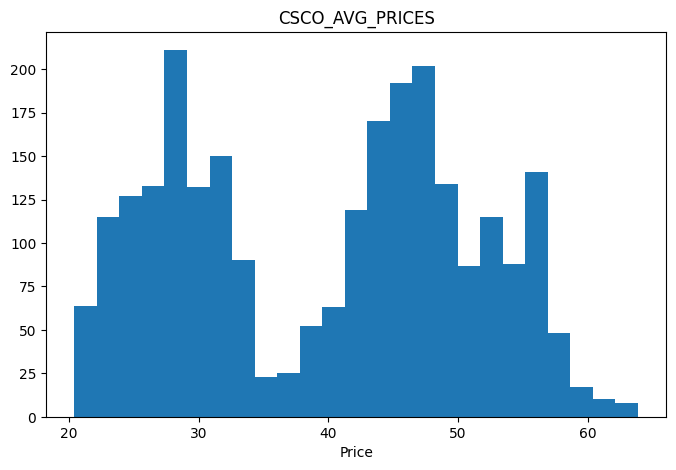

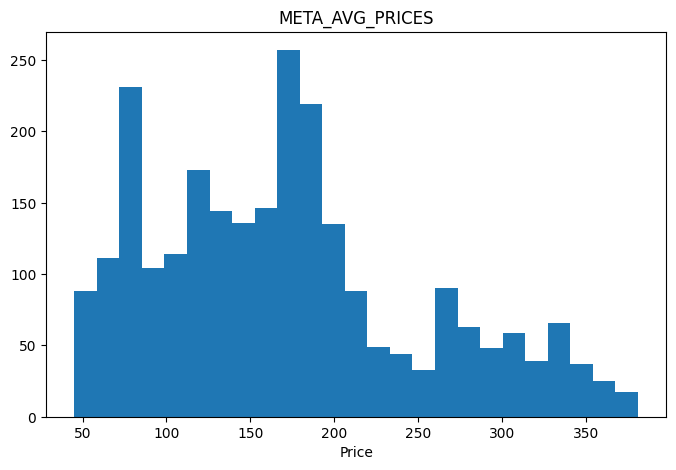

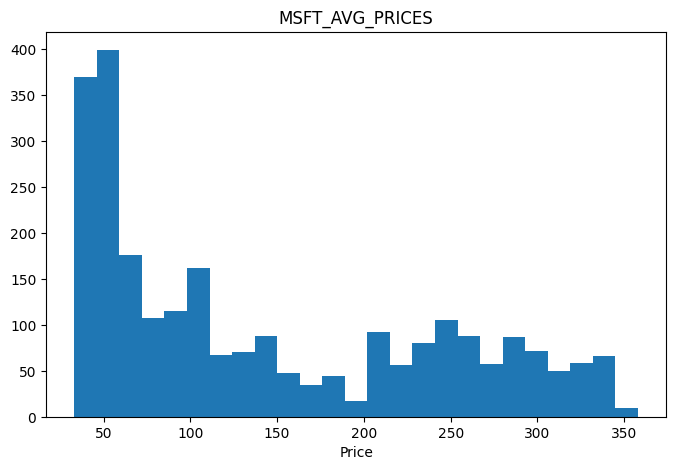

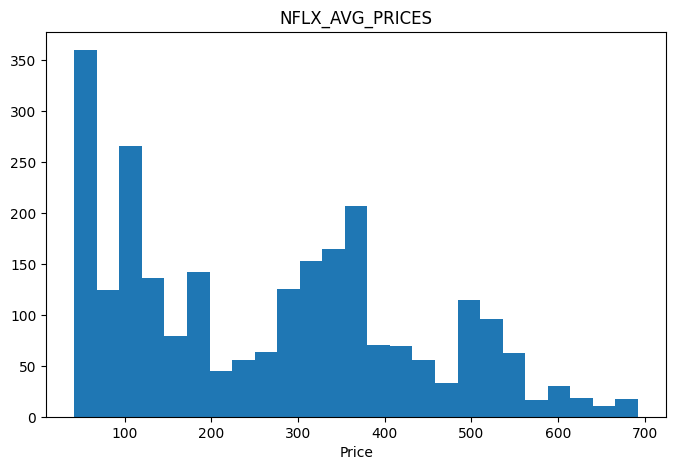

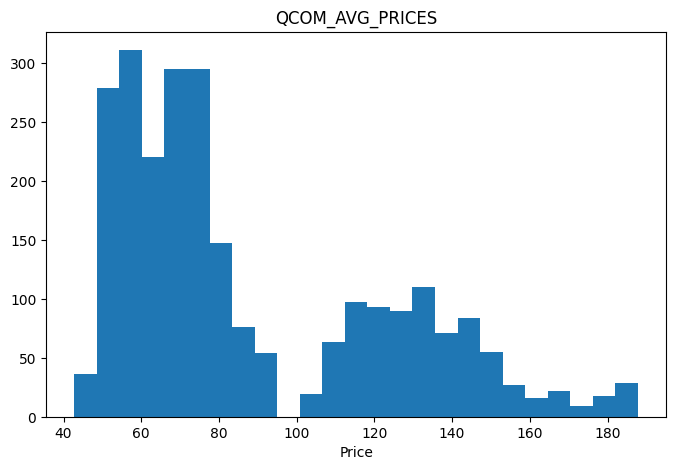

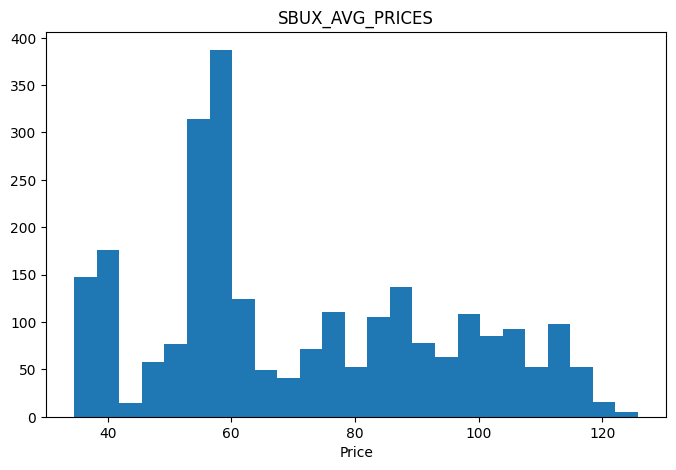

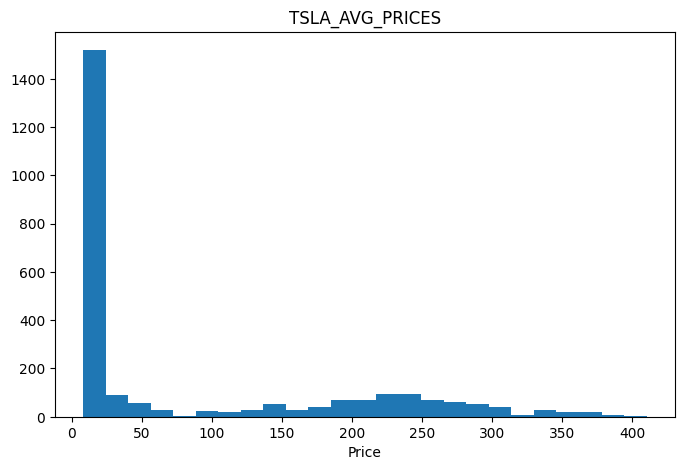

In [209]:
stock_labels = stock_market['Label'].unique()

ochl_labels = ['Open', 'Close/Last', 'High', 'Low']

# for label in stock_labels[:5]:
for label in stock_labels:
    ind_stock = stock_market[stock_market['Label'] == label]
    ind_stock_price_avg = ind_stock[ochl_labels].mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.hist(ind_stock_price_avg, bins=25)
    plt.xlabel('Price')
    plt.title(label + '_AVG_PRICES')


    # for x in range(1, 5):
    #     plt.subplot(2, 2, x)
    #     plt.hist(ind_stock[ochl_labels[x-1]], bins=50)
    #     plt.xlabel('Price')
    #     plt.title(label + '_' + ochl_labels[x-1])

    plt.show()



What we see here is that the average price of each stock over some 10 years or so ranges *wildly*. Meaning that we can't really reliably trust the previous analysis we made for the sake of simulating and generating OCHL metrics in our fake stock market. That being said I would not be surprised if that data is still relatively useful when building and training a predictive model (alas, that is for a later day).

So?

### Percentages.

Percentages. Percentage. Percent. Perc-. You get the idea, but most importantly *why?* 
> Reminder to self, read `Start with Why`, by *Simon Sinek*

By tracking a percentage of deviation from a day's 'global average' to each `OCHL` data-point, we eliminate the impact of these massive price ranges, and their change over time because if we plot out these global averages, we will without a doubt see an increase in the stock price as the years go on. These are big companies we are looking at, let's be honest.

In fact, let's take a look at the these global averages in a simple line plot.


##### Fork in the Road
While trying to get these plotted properly, I began running into some issues, like the following:

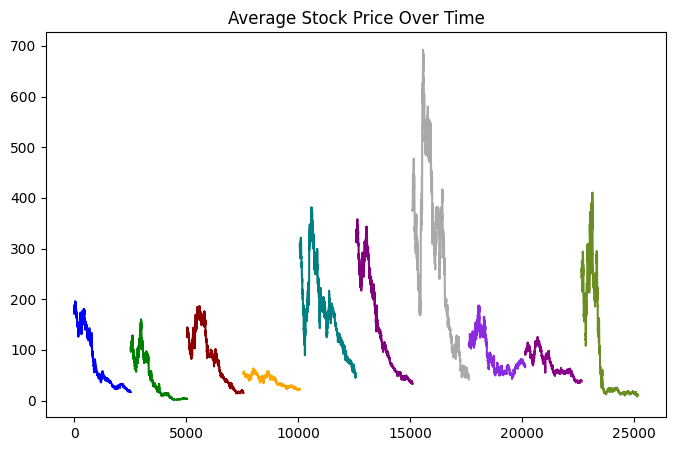

In [210]:
stock_labels = stock_market['Label'].unique()

ochl_labels = ['Open', 'Close/Last', 'High', 'Low']
c = ['blue', 'green', 'darkred', 'orange', 'teal', 
     'purple', 'darkgrey', 'blueviolet', 'darkmagenta', 'olivedrab',
     'firebrick',  'sienna', 'orangered', 'maroon', 'seagreen']

plt.figure(figsize=(8, 5))

# for label in stock_labels[:5]:
for x in range(len(stock_labels)):
    ind_stock = stock_market[stock_market['Label'] == stock_labels[x]]
    ind_stock_price_avg = ind_stock[ochl_labels].mean(axis=1)

    plt.plot(ind_stock_price_avg, c=c[x], label=stock_labels[x])

plt.title('Average Stock Price Over Time')
plt.show()

And this is clearly not what we wanted for a few reasons...

1. It's all plotted one after the other, instead of all plotting along the same axis in time
2. The dates are in reverse (due to the nature of the dataset).

**So... we actually have a few other things to do first...**

#### A Path Appears in the Forest

What we need to do is change our `read_clean_data` function, as well as modify `gather_stock_data`.

In `read_clean_data` we are going to reverse the entire dataset, so it is in proper sequential time. In `gather_stock_data`, we add the option to return the individual datasets instead of concatenating them in one go. The changes work as following:

In [211]:
def read_clean_data(file, ochl_only=False):
    file_path = 'data/' + file

    data = pd.read_csv(file_path)

    data = data.loc[::-1].reset_index(drop=True)

    filename = file.split('_')
    stock_label = filename[0]

    data.insert(0, 'Label', value=stock_label)
    
    vol = data.pop('Volume')
    data.insert(2, 'Volume', vol)

    ochl_columns = ['Open', 'Close/Last', 'High', 'Low']

    for column in ochl_columns:
        data[column] = data[column].str.replace('$', '').astype('float64')

    if ochl_only:
        return data[ochl_columns]

    return data

filename = 'AAPL_historical.csv'

aapl = read_clean_data(filename)

aapl.head()

,Label,Date,Volume,Close/Last,Open,High,Low
0,AAPL,09/30/2013,259059760,17.0268,17.0446,17.2021,16.9433
1,AAPL,10/01/2013,352776899,17.4271,17.0875,17.4693,17.0850
2,AAPL,10/02/2013,287196445,17.4843,17.3439,17.5643,17.2768
3,AAPL,10/03/2013,315209314,17.2646,17.5182,17.5839,17.1692
4,AAPL,10/04/2013,258552177,17.2511,17.2807,17.3071,17.0929


In [212]:
def gather_stock_data(filenames, concat=True):
    data = []

    for file in filenames:
        data_set = read_clean_data(file)
        data.append(data_set)
    
    if concat:
        stock_market = pd.concat(data, axis=0, ignore_index=1)

        return stock_market
    
    return data

ind_stocks = gather_stock_data(filenames, concat=False)
ind_stocks

[     Label        Date     Volume  Close/Last      Open      High       Low
 0     AAPL  09/30/2013  259059760     17.0268   17.0446   17.2021   16.9433
 1     AAPL  10/01/2013  352776899     17.4271   17.0875   17.4693   17.0850
 2     AAPL  10/02/2013  287196445     17.4843   17.3439   17.5643   17.2768
 3     AAPL  10/03/2013  315209314     17.2646   17.5182   17.5839   17.1692
 4     AAPL  10/04/2013  258552177     17.2511   17.2807   17.3071   17.0929
 ...    ...         ...        ...         ...       ...       ...       ...
 2511  AAPL  09/21/2023   63149120    173.9300  174.5500  176.3000  173.8600
 2512  AAPL  09/22/2023   56725390    174.7900  174.6700  177.0790  174.0500
 2513  AAPL  09/25/2023   46172740    176.0800  174.2000  176.9700  174.1500
 2514  AAPL  09/26/2023   64588950    171.9600  174.8200  175.2000  171.6600
 2515  AAPL  09/27/2023   66921810    170.4300  172.6200  173.0400  169.0500
 
 [2516 rows x 7 columns],
      Label        Date    Volume  Close/Last   

Now each stock is separate and in sequential time-order. Perfect!

#### Back to Plotting

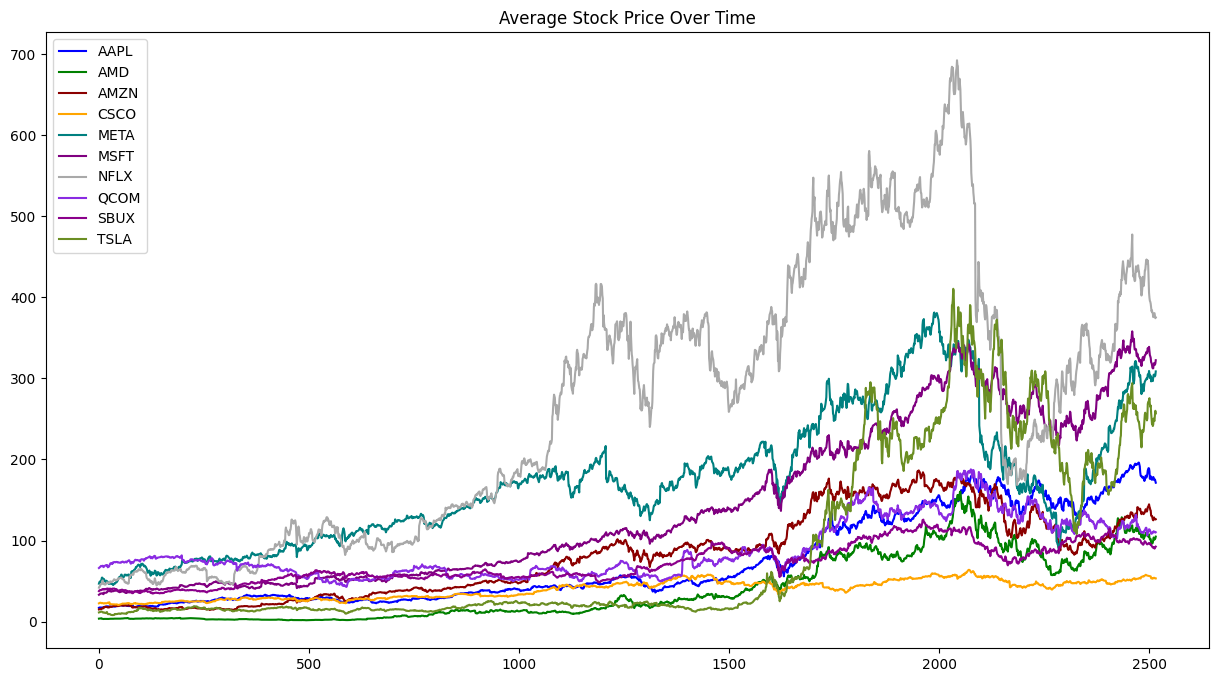

In [213]:
stock_labels = stock_market['Label'].unique()

ochl_labels = ['Open', 'Close/Last', 'High', 'Low']
c = ['blue', 'green', 'darkred', 'orange', 'teal', 
     'purple', 'darkgrey', 'blueviolet', 'darkmagenta', 'olivedrab',
     'firebrick',  'sienna', 'orangered', 'maroon', 'seagreen']

plt.figure(figsize=(15, 8))

# for label in stock_labels[:5]:
for x in range(len(stock_labels)):
    ind_stock = ind_stocks[x]
    ind_stock_price_avg = ind_stock[ochl_labels].mean(axis=1)

    plt.plot(ind_stock_price_avg, c=c[x], label=stock_labels[x])

plt.title('Average Stock Price Over Time')
plt.legend(loc='upper left')
plt.show()


Now that's much better. So we see the problem clearly, both in the histograms and in the above chart. The prices do not remain consistent, and thus if we seek to gain the insight we desire using the previous method, we run into trouble. This is why we want to use percentages. 

Luckily, calculating the percentages are pretty easy. 

If we are working from a day's "global average", all we need to do is calculate that average, and the perform the following calculation from that average to each `OCHL` data point. 

$$
\begin{equation}
\%\text{Change} = \frac{n_{i} - x_{avg}}{x_{avg}} * 100
\end{equation}
$$

Where 
- $n_{i}$ is the current `OCHL` metric we are calculating for and,
- $x_{avg}$ is the global average of that day

In [214]:
def ochl_percent_dist(data):
    data['avg_all'] = data.mean(axis=1)

    data['o_percent'] = (data['Open'] - data['avg_all']) / data['avg_all'] * 100
    data['c_percent'] = (data['Close/Last'] - data['avg_all']) / data['avg_all'] * 100
    data['h_percent'] = (data['High'] - data['avg_all']) / data['avg_all'] * 100 
    data['l_percent'] = (data['Low'] - data['avg_all']) / data['avg_all'] * 100

    return data


ochl_stocks = extract_ochl(stock_market)

ochl_p_changes = ochl_percent_dist(ochl_stocks)


ochl_p_changes



C:\Users\kylec\AppData\Local\Temp\ipykernel_31128\281098179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_all'] = data.mean(axis=1)
C:\Users\kylec\AppData\Local\Temp\ipykernel_31128\281098179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['o_percent'] = (data['Open'] - data['avg_all']) / data['avg_all'] * 100


,Close/Last,Open,High,Low,avg_all,o_percent,c_percent,h_percent,l_percent
0,170.4300,172.6200,173.0400,169.0500,171.285000,0.779403,-0.499168,1.024608,-1.304843
1,171.9600,174.8200,175.2000,171.6600,173.410000,0.813102,-0.836169,1.032236,-1.009169
2,176.0800,174.2000,176.9700,174.1500,175.350000,-0.655831,0.416310,0.923867,-0.684346
3,174.7900,174.6700,177.0790,174.0500,175.147250,-0.272485,-0.203971,1.102929,-0.626473
4,173.9300,174.5500,176.3000,173.8600,174.660000,-0.062980,-0.417955,0.938967,-0.458033
...,...,...,...,...,...,...,...,...,...
25155,12.2627,12.3520,12.5859,12.2120,12.353150,-0.009309,-0.732202,1.884135,-1.142624
25156,11.9813,11.6667,12.1667,11.6100,11.856175,-1.598112,1.055357,2.619099,-2.076344
25157,11.9133,11.5167,11.9525,11.4133,11.698950,-1.557832,1.832216,2.167289,-2.441672
25158,11.5287,11.5393,11.7167,11.3127,11.524350,0.129725,0.037746,1.669075,-1.836546


In [215]:
ochl_p_changes.describe()

,Close/Last,Open,High,Low,avg_all,o_percent,c_percent,h_percent,l_percent
count,25160.000000,25160.000000,25160.000000,25160.000000,25160.000000,25160.000000,25160.000000,25160.000000,25160.000000
mean,106.334450,106.315350,107.763547,104.835632,106.312245,-0.000736,0.024046,1.298619,-1.321929
std,103.777377,103.791807,105.342547,102.173730,103.761307,0.986788,0.974751,0.935291,0.930885
min,1.620000,1.620000,1.690000,1.610000,1.650000,-11.080139,-9.647516,0.148082,-12.899384
25%,38.719250,38.720000,39.012500,38.373750,38.714375,-0.490745,-0.456071,0.693901,-1.641520
50%,69.800000,69.580000,70.495000,68.910000,69.695250,-0.007026,0.026265,1.049267,-1.065867
75%,139.505000,139.702500,141.405000,137.652500,139.699375,0.478082,0.505056,1.611894,-0.710417
max,691.690000,692.350000,700.989400,686.090000,692.192350,9.171965,11.219512,27.064023,-0.156914


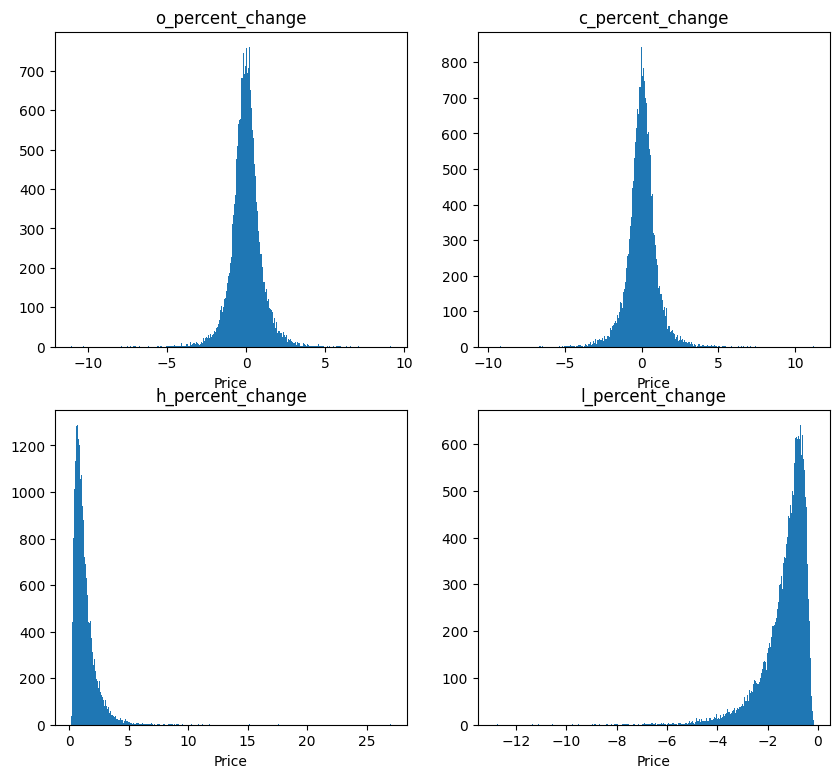

In [216]:
plt.figure(figsize=(10, 9))

ochl_labels = ['o_percent', 'c_percent', 'h_percent', 'l_percent']

for x in range(1, 5):
    plt.subplot(2, 2, x)
    plt.hist(ochl_p_changes[ochl_labels[x-1]], bins=400)
    plt.xlabel('Price')
    plt.title(ochl_labels[x-1] + '_change')

plt.show()

# Money!

Now, for ease of access, we're going to quickly save this information to a `.csv` file and then wrap this journal up.

In [217]:
ochl_p_changes_only = ochl_p_changes[['o_percent', 'c_percent', 'h_percent', 'l_percent']]

ochl_summary_stats = ochl_p_changes_only.describe()
ochl_summary_stats

,o_percent,c_percent,h_percent,l_percent
count,25160.000000,25160.000000,25160.000000,25160.000000
mean,-0.000736,0.024046,1.298619,-1.321929
std,0.986788,0.974751,0.935291,0.930885
min,-11.080139,-9.647516,0.148082,-12.899384
25%,-0.490745,-0.456071,0.693901,-1.641520
50%,-0.007026,0.026265,1.049267,-1.065867
75%,0.478082,0.505056,1.611894,-0.710417
max,9.171965,11.219512,27.064023,-0.156914


In [218]:
import os

os.makedirs('analytics', exist_ok=True)
ochl_p_changes.to_csv('analytics/ochl_p_changes.csv')
ochl_p_changes_only.to_csv('analytics/ochl_p_changes_only.csv')
ochl_summary_stats.to_csv('analytics/ochl_summary_stats.csv')


ochl_p_changes

,Close/Last,Open,High,Low,avg_all,o_percent,c_percent,h_percent,l_percent
0,170.4300,172.6200,173.0400,169.0500,171.285000,0.779403,-0.499168,1.024608,-1.304843
1,171.9600,174.8200,175.2000,171.6600,173.410000,0.813102,-0.836169,1.032236,-1.009169
2,176.0800,174.2000,176.9700,174.1500,175.350000,-0.655831,0.416310,0.923867,-0.684346
3,174.7900,174.6700,177.0790,174.0500,175.147250,-0.272485,-0.203971,1.102929,-0.626473
4,173.9300,174.5500,176.3000,173.8600,174.660000,-0.062980,-0.417955,0.938967,-0.458033
...,...,...,...,...,...,...,...,...,...
25155,12.2627,12.3520,12.5859,12.2120,12.353150,-0.009309,-0.732202,1.884135,-1.142624
25156,11.9813,11.6667,12.1667,11.6100,11.856175,-1.598112,1.055357,2.619099,-2.076344
25157,11.9133,11.5167,11.9525,11.4133,11.698950,-1.557832,1.832216,2.167289,-2.441672
25158,11.5287,11.5393,11.7167,11.3127,11.524350,0.129725,0.037746,1.669075,-1.836546
